In [1]:
#Importing Necessary files to read Images
import os
import cv2
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from matplotlib import gridspec
strategy = tf.distribute.MirroredStrategy()
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


In [3]:
ROOT_DIR = "/kaggle/input/datascience-dataset/processed/"


In [4]:
#Printing random images from the dataset
import os

train_folder = ROOT_DIR + "train"
valid_folder = ROOT_DIR + "val"
test_folder = ROOT_DIR + "test"

dir_list=os.listdir(train_folder)
dir_list.sort()

# Create a dictionary from class_list and one_hot_list
class_dict = {i: dir_list[i] for i in range(len(dir_list))}

one_hot_list = [[1, 0, 0, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 1, 0, 0],
               [0, 0, 0, 1, 0],
               [0, 0, 0, 0, 1]
              ]

# Create a dictionary from class_list and one_hot_list
one_hot_dict = {dir_list[i]: one_hot_list[i] for i in range(len(dir_list))}

# Print the resulting dictionary
print(class_dict)
print(one_hot_dict)

print(dir_list)
EPOCHS=15


{0: 'leaf_waste', 1: 'metal', 2: 'paper', 3: 'plastic', 4: 'wood_waste'}
{'leaf_waste': [1, 0, 0, 0, 0], 'metal': [0, 1, 0, 0, 0], 'paper': [0, 0, 1, 0, 0], 'plastic': [0, 0, 0, 1, 0], 'wood_waste': [0, 0, 0, 0, 1]}
['leaf_waste', 'metal', 'paper', 'plastic', 'wood_waste']


In [5]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    train_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    color_mode='rgb',
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    valid_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    color_mode='rgb',
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

ds_test_ = image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    color_mode='rgb',
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5037 files belonging to 5 classes.
Found 917 files belonging to 5 classes.
Found 125 files belonging to 5 classes.


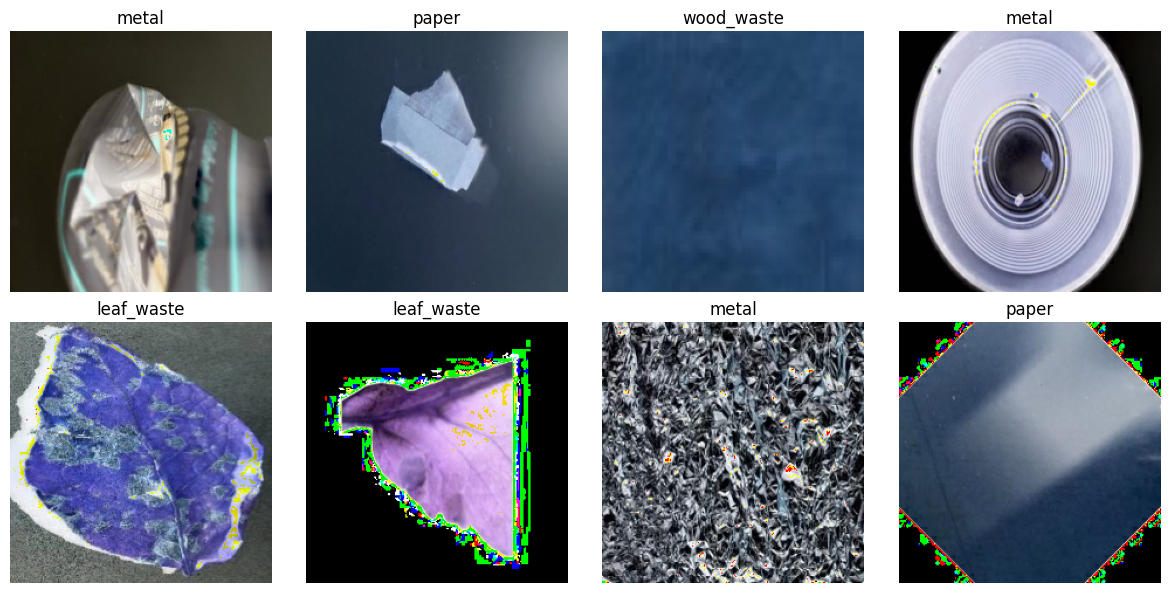

In [6]:

import matplotlib.pyplot as plt

# Assuming `ds_train_` is your training dataset

# Retrieve a batch of images and labels from the dataset
for images, labels in ds_train_.take(1):
    # Convert one-hot encoded labels to class indices
    class_indices = tf.argmax(labels, axis=1)

    # Display the images and their labels
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()
    for i in range(len(axs)):
        # Convert image tensor to NumPy array and rescale pixel values
        image = (images[i] * 255).numpy().astype(int)

        # Display the image and its corresponding label
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f"{class_dict[class_indices.numpy()[i]]}")
    plt.tight_layout()
    plt.show()


Learning rate schedule: 1e-05 to 5e-05 to 1.54e-05


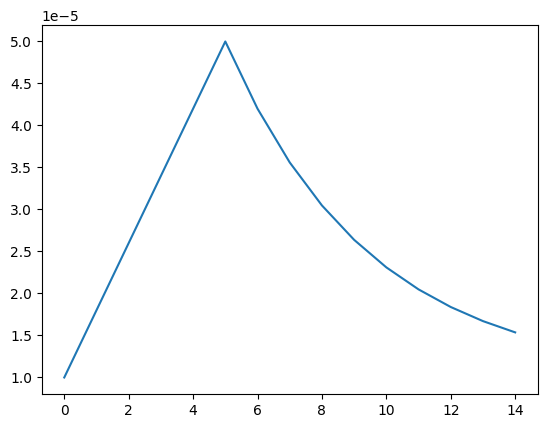

In [7]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


In [8]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [9]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
with strategy.scope():
    base_model = tf.keras.applications.xception.Xception(
      weights='imagenet',
      input_shape=[224,224, 3],
      include_top=False)
    base_model.trainable = True
    model = keras.Sequential([
        layers.InputLayer(input_shape=[224, 224, 3]),
        # Data Augmentation
        preprocessing.RandomFlip(mode='horizontal'),
        preprocessing.RandomFlip(mode='vertical'),
        preprocessing.RandomRotation(factor=0.10),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        base_model,

        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.BatchNormalization(renorm=True),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(renorm=True),
        layers.Dense(5, activation='softmax'),
    ])


83683744/83683744 [==============================] - 0s 0us/step


In [11]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    callbacks=[lr_callback, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
79/79 [==============================] - 91s 606ms/step - loss: 1.0230 - categorical_accuracy: 0.6051 - val_loss: 0.3384 - val_categorical_accuracy: 0.8735 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/15
79/79 [==============================] - 42s 526ms/step - loss: 0.2787 - categorical_accuracy: 0.9041 - val_loss: 0.1753 - val_categorical_accuracy: 0.9444 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/15
79/79 [==============================] - 42s 526ms/step - loss: 0.1799 - categorical_accuracy: 0.9394 - val_loss: 0.1562 - val_categorical_accuracy: 0.9586 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/15
79/79 [==============================] - 42s 526ms/step - loss: 0.1270 - categorical_accuracy: 0.9563 - val_loss: 0.1252

/tmp/ipykernel_47/1595747826.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


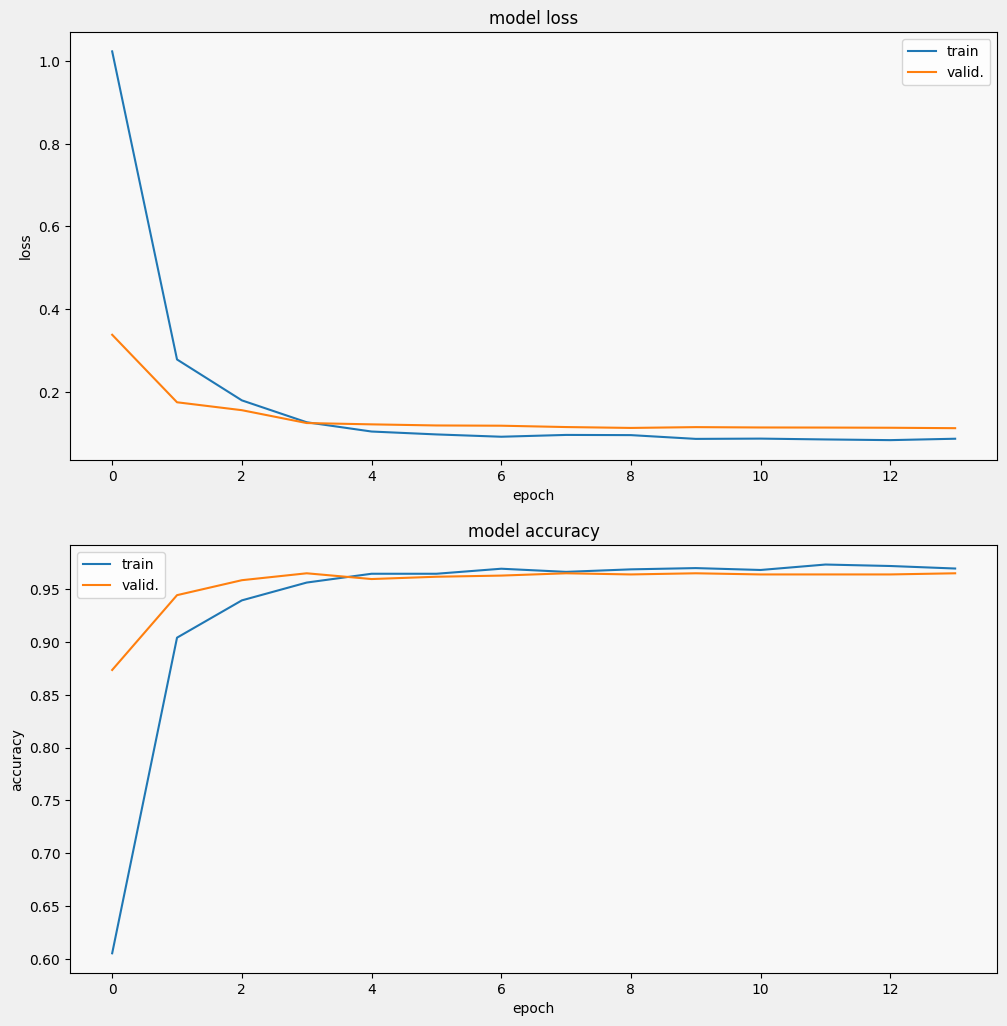

In [12]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
    'accuracy',
    212,
)

In [20]:
import numpy as np

# Extract the labels from the dataset
labels = np.concatenate([y for x, y in ds_test_], axis=0)

# Convert the labels from one-hot encoding to class indices
true_labels = np.argmax(labels, axis=1)


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Get the predictions for the validation data
predictions = np.argmax(model.predict(ds_test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Generate the classification report
report = classification_report(true_labels, predictions)

print("\nClassification Report:")
print(report)


2/2 [==============================] - 0s 137ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.89      0.96      0.92        25
           2       0.85      0.92      0.88        25
           3       0.95      0.80      0.87        25
           4       1.00      1.00      1.00        25

    accuracy                           0.94       125
   macro avg       0.94      0.94      0.94       125
weighted avg       0.94      0.94      0.94       125



In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
accuracy = accuracy_score(
    true_labels,
    predictions)
score = f1_score(
    true_labels,
    predictions,
    labels=np.argmax(labels,axis=1),
    average='weighted',
)
precision = precision_score(
    true_labels,
    predictions,
    labels=np.argmax(labels,axis=1),
    average='weighted',
)
recall = recall_score(
    true_labels,
    predictions,
    labels=np.argmax(labels,axis=1),
    average='weighted',
)

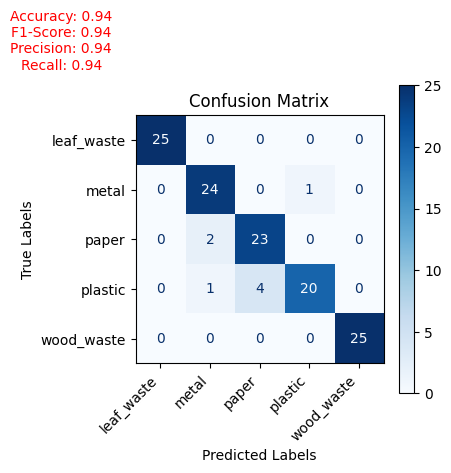

In [25]:
# Calculate metrics
classification_rep = classification_report(true_labels, predictions, target_names=class_dict.values(), output_dict=True)


# Plot the confusion matrix with metrics
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_dict.values())
fig, ax = plt.subplots(figsize=(4, 4))
ax = plt.gca()
disp.plot(ax=ax, cmap='Blues')

ax.text(-2,-2, f'Accuracy: {accuracy:.2f}\nF1-Score: {score:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}', ha='center', va='center', color='red')

# Set plot labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [29]:
model.save('/kaggle/working/done')


In [30]:
import shutil

directory_path = '/kaggle/working/done'  # Replace with your directory path

# Create a zip file of the directory
shutil.make_archive('/kaggle/working/done', 'zip', directory_path)

# Download the zip file
from IPython.display import FileLink
display(FileLink('/kaggle/working/done.zip'))

/kaggle/working/done.zip